In [2]:
import re
import os
import math
import copy
import pickle
import random
import numpy as np
import pandas as pd
import emoji as emoji
from datetime import datetime
from textblob import TextBlob
from collections import Counter

from sklearn import preprocessing, svm, linear_model, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('Tweets.csv')

# Preprocessing

In [3]:
# version 1 -> only remove @ and http:// 
def sub_remove_v1(data):
    val = re.sub('@', "",data["text"]) 
    val = re.sub(r" http\S+","",val) # remove http://
    return val
data['remove_1'] = data.apply(sub_remove_v1, axis=1)

In [4]:
# Version 2 -> # remove anything starts with @ and http://
def sub_remove_v2(data):
    val = re.sub(r"@\S+", "",data["text"])
    val = re.sub(r" http\S+","",val)
    return val
data['remove_2'] = data.apply(sub_remove_v2, axis=1)

In [5]:
# version 3 -> remove @, #, http:// 
# with removing #hash, we now treat hashtag has an indiviaul word. this version is to explore if the hashtag really helps or not 
def sub_remove_v3(data):
    val = re.sub('@', "",data["text"]) 
    val = re.sub(r"http\S+","",val) # remove http://
    val = re.sub('#', "",val) 
    return val
data['remove_3'] = data.apply(sub_remove_v3, axis=1)

In [6]:
# version 4 -> collect hashtag 
#(i want to use this an innvatoive way -> with this, to just simply count the # of time in positive nad negative. 
#however, it needs to be well balanced.)
def sub_remove_v4(data):
    val = re.findall(r'#\S+',data["text"])
    return ' '.join(val) 

data['remove_4'] = data.apply(sub_remove_v4, axis=1) 
# I think this may use for additional features.. can we have BOW and also some other features at the same time?

In [7]:
#version 5 -> convert emoji @ and http 
def sub_remove_v5(data):
    file = data['text']
    words = file.split(' ')
    for i in range(len(words)):
        try:
            words[i] = emoji.demojize(words[i])
            if words[i][:-1] in emoji.EMOJI_UNICODE.keys():
                words[i] = re.sub(r"_"," ",re.sub(r" ","",re.sub(r":","",words[i])[:-1]))
            else:
                pass
        except:
            pass
    
    val =  ' '.join(words)
    val = re.sub('@', "",val) 
    val = re.sub(r"http\S+","",val)
    return val 

            
data['remove_5'] = data.apply(sub_remove_v5, axis=1)

In [8]:
#version 6 -> 1) emoji 2) remove @ 3) remove http 4) remove # and repeat hashtags 
def sub_remove_v6(data,hashtag_weight=1,remove_hash = 1):
    file = data['text']
    words = file.split(' ')
    for i in range(len(words)):
        try:
            words[i] = emoji.demojize(words[i])
            if words[i][:-1] in emoji.EMOJI_UNICODE.keys():
                words[i] = re.sub(r"_"," ",re.sub(r" ","",re.sub(r":","",words[i])[:-1]))
            else:
                pass
        except:
            pass
    
    val =  ' '.join(words)
    val = re.sub('@', "",val) 
    val = re.sub(r"http:\S+","",val)
      
    hashtag = re.findall(r'#\S+',val)
    length = len(hashtag)
    if length>0:
        output = ' '.join(hashtag * hashtag_weight)
        result = val + ' '+ output 
        
    else:
        result = val 
    if remove_hash == 1:
        
        result =re.sub(r"#","",result)
    
    return result 

            
data['remove_6'] = data.apply(sub_remove_v6,args = (1,0) ,axis=1) # 4-> means total 5 times # 1 means remove #

In [9]:
data.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                         ...                         tweet_coord  \
0                        ...                                 NaN   
1                        ...                                 NaN   
2                        ...                                 NaN   
3                        ...                                 NaN   
4                        ...                                 NaN   

               tweet_created tweet_location               user_timezone  \
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)   
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)   
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)   
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)   
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)   

                                            remove_1  \
0                  VirginAmerica What dhepburn said.   
1  VirginAmerica plus you've added commercials to...   
2  VirginAmerica I didn't today... Must mean I ne...   
3  VirginAmerica it's really aggressive to blast ...   
4  VirginAmerica and it's a really big bad thing ...   

                                            remove_2  \
0                                        What  said.   
1   plus you've added commercials to the experien...   
2   I didn't today... Must mean I need to take an...   
3   it's really aggressive to blast obnoxious "en...   
4           and it's a really big bad thing about it   

                                            remove_3 remove_4  \
0                  VirginAmerica What dhepburn said.            
1  VirginAmerica plus you've added commercials to...            
2  VirginAmerica I didn't today... Must mean I ne...            
3  VirginAmerica it's really aggressive to blast ...            
4  VirginAmerica and it's a really big bad thing ...            

                                            remove_5  \
0                  VirginAmerica What dhepburn said.   
1  VirginAmerica plus you've added commercials to...   
2  VirginAmerica I didn't today... Must mean I ne...   
3  VirginAmerica it's really aggressive to blast ...   
4  VirginAmerica and it's a really big bad thing ...   

                                            remove_6  
0                  VirginAmerica What dhepburn said.  
1  VirginAmerica plus you've added commercials to...  
2  VirginAmerica I didn't today... Must mean I ne...  
3  VirginAmerica it's really aggressive to blast ...  
4  VirginAmerica and it's a really big bad thing ...  

[5 rows x 21 columns]

# Using original data

In [10]:
y_raw = data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
y = le.transform(y_raw)

In [11]:
tweet = data['text']

In [12]:
def plotRocCurve(X_train, y_train, X_valid, y_valid, model, modelname):
    if modelname == 'RandomForest':
        y_score = model.fit(X_train, y_train).predict_proba(X_valid)
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_valid)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_valid, y_score[:,i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    print(sum(roc_auc.values()) / len(roc_auc))

    label_list = ['negative', 'neutral', 'positive']
    fig = plt.figure(figsize = (6, 6))

    # Plot ROC curve
    for i in range(3):
        roc_auc = auc(fpr[i],tpr[i])
        plt.plot(fpr[i],tpr[i], label = label_list[i] + ' (AUC = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0]) 
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC_' + modelname)
        plt.legend(loc="lower right")
        #plt.savefig('ROC_' + modelname + '.jpg')

## Unigrams

In [13]:
# get word counts
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

### One Vs Rest with Linear SVM

In [192]:
def w_accuracy(m,fn_cost = 1, fp_cost = 3 ):
    fn = (m[0,1]+m[0,2]) * fn_cost
    fp = (m[1,0]+m[2,0]) * fp_cost 
    t = sum(sum(m))
    return ((t-fn-fp)/t)

In [19]:
# One Vs Rest
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.807035519126


array([[1725,  125,   39],
       [ 202,  328,   50],
       [  93,   56,  310]])

In [38]:
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.641734972678
0.440232240437


0.905171840389


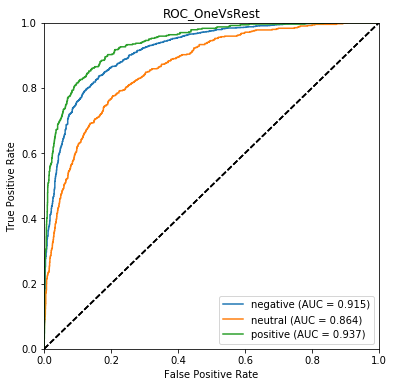

In [103]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

### One Vs One with Linear SVM

In [39]:
# One Vs One
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.800887978142
0.654371584699
0.468579234973


0.890102942598


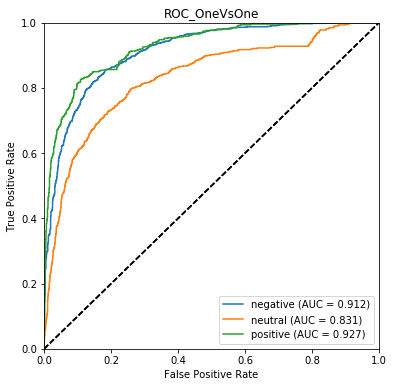

In [16]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

### Gradient Boosting

In [40]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5, n_estimators=500)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.799863387978
0.618852459016
0.399590163934


0.853717587832


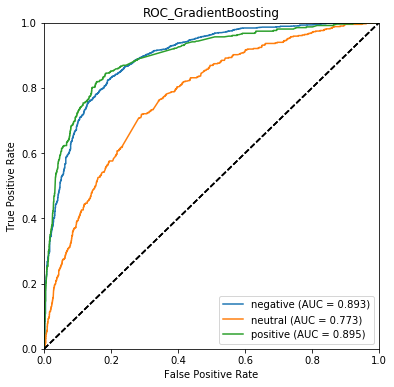

In [17]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [41]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.775273224044
0.46106557377
0.116803278689


0.889357698042


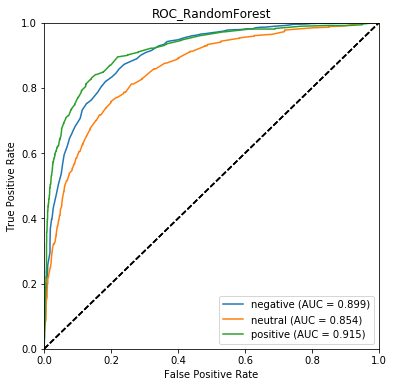

In [19]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [42]:
clf_log=linear_model.LogisticRegression(C=0.35)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.805669398907
0.637295081967
0.433743169399


0.905526767319


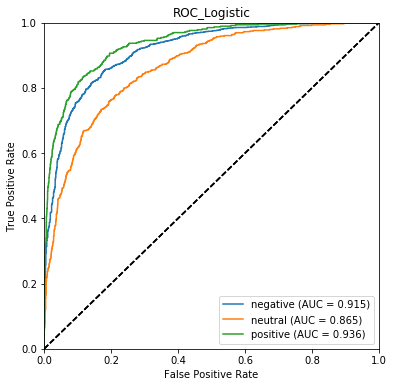

In [21]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

## Tf-Idf

In [100]:
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df=0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [101]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.760587431694
0.364754098361
-0.0505464480874


0.892332474549


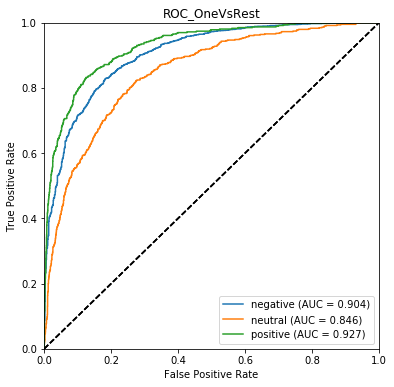

In [24]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [102]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.25))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.811133879781
0.628756830601
0.411543715847


0.893672951702


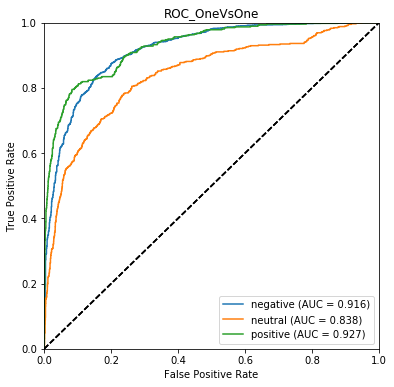

In [26]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [103]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.779371584699
0.54781420765
0.282103825137


0.834466530596


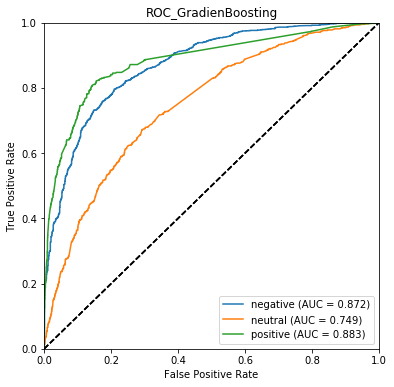

In [28]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [104]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.766393442623
0.462090163934
0.125341530055


0.873690374955


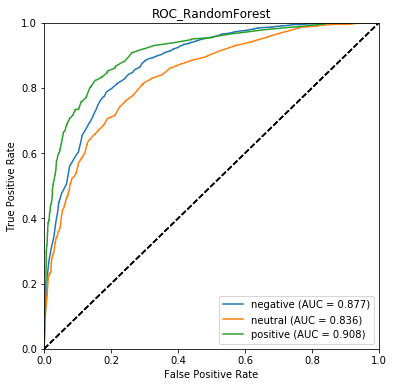

In [30]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [105]:
clf_log=linear_model.LogisticRegression(C=3.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.813866120219
0.633538251366
0.419057377049


0.905743506644


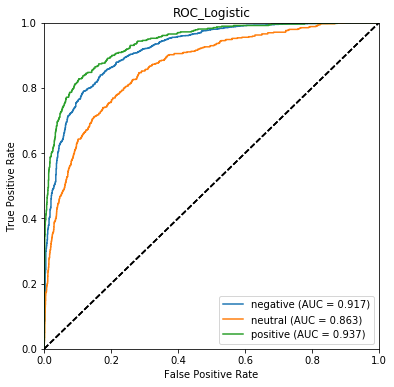

In [32]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

## Bi-grams

In [106]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.811133879781
0.658469945355
0.467896174863


0.911533619896


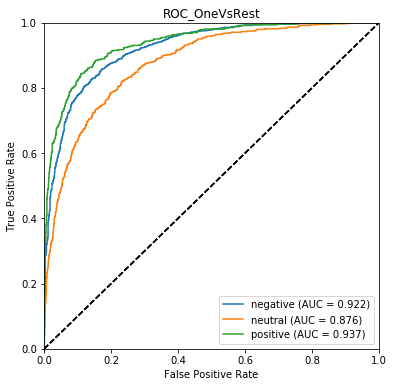

In [37]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [108]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.80737704918
0.664275956284
0.481215846995


0.897020681132


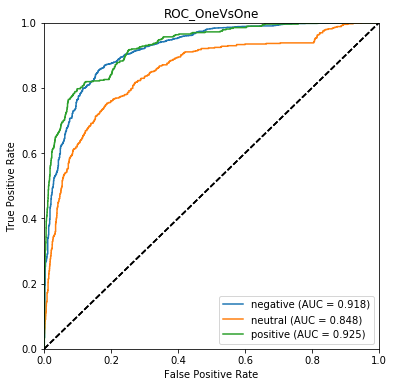

In [39]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [109]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.795765027322
0.57718579235
0.323087431694


0.843392802973


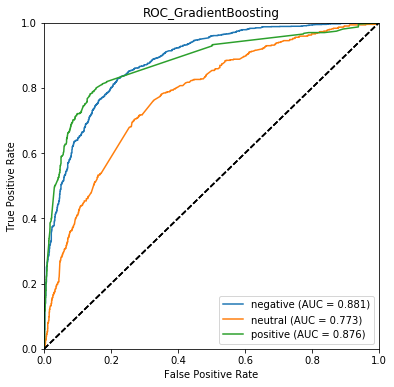

In [41]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [110]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.767076502732
0.434426229508
0.073087431694


0.885827935381


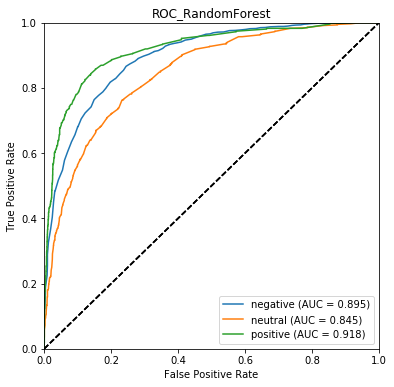

In [43]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [111]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.811133879781
0.662226775956
0.474385245902


0.911868212037


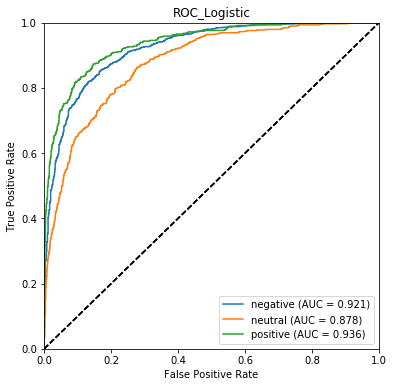

In [45]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Tri-grams

In [112]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.813524590164
0.656079234973
0.461407103825


0.911028530716


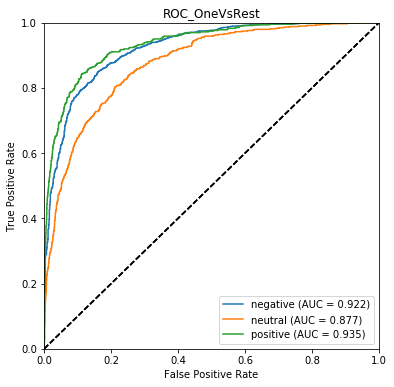

In [48]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [114]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.806693989071
0.65881147541
0.471653005464


0.896016249774


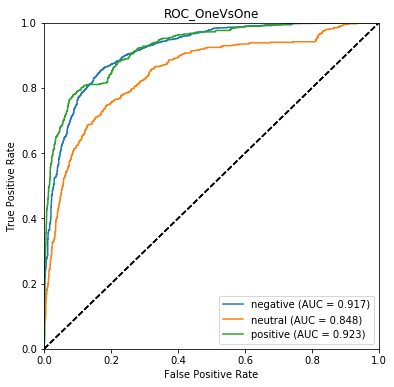

In [50]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [115]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.798155737705
0.583333333333
0.333333333333


0.84685327874


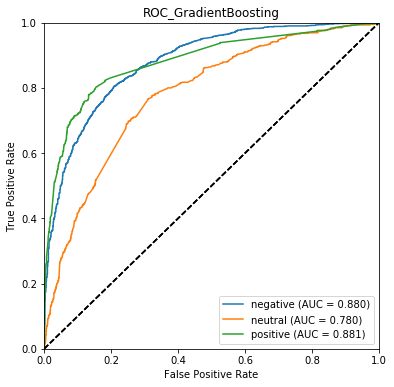

In [52]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [116]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.761270491803
0.416666666667
0.0443989071038


0.885046986446


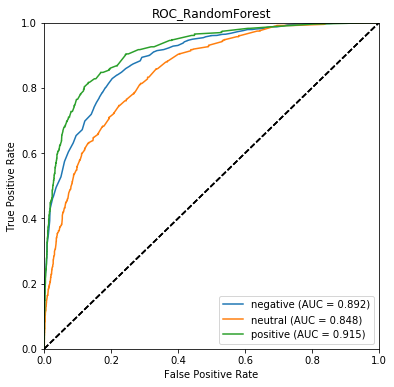

In [54]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [117]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.808743169399
0.645491803279
0.444672131148


0.911249761076


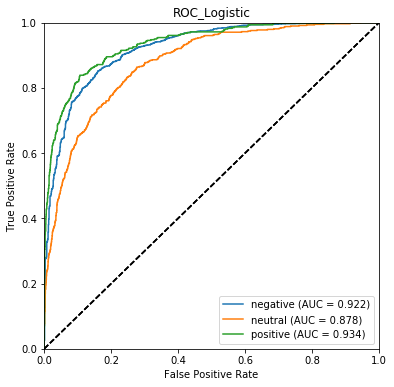

In [56]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Balanced data

In [118]:
data = shuffle(data,random_state=42)

index = list()
pos_count = 0
neg_count = 0 
neu_count = 0

for i in range(data.shape[0]):
    if data.iloc[i]["airline_sentiment"] == "positive":
        if pos_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue 
        pos_count += 1 
    elif data.iloc[i]["airline_sentiment"] == "negative":
        if neg_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neg_count += 1 
    else:
        if neu_count <1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neu_count += 1 
        
balanced_data = data.filter(index,axis = 0)

In [119]:
y_raw = balanced_data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
le.classes_
y = le.transform(y_raw)

In [120]:
tweet = balanced_data['text']

In [121]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.749559082892
0.723104056437
0.596119929453


0.894249567692


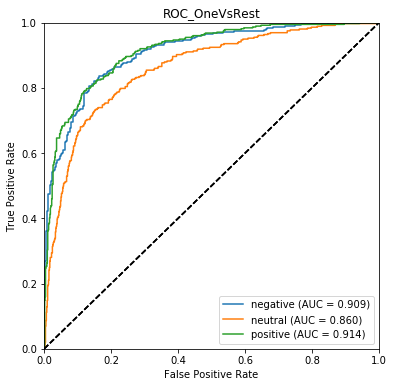

In [15]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [123]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.743386243386
0.723985890653
0.597001763668


0.885930222444


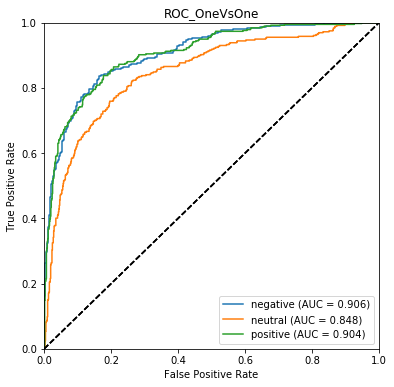

In [17]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [124]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.731922398589
0.701940035273
0.573192239859


0.844603357633


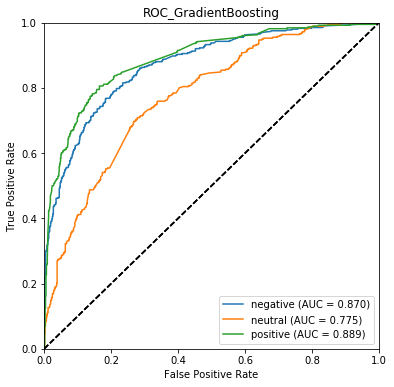

In [66]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [125]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.738095238095
0.703703703704
0.569664902998


0.887973889014


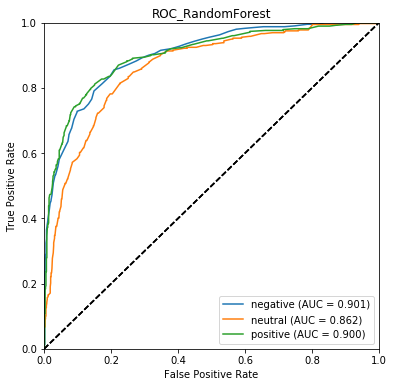

In [68]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [126]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.751322751323
0.714285714286
0.58024691358


0.894731977958


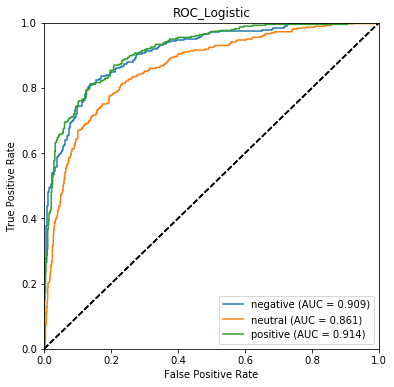

In [19]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [20]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [127]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.80806010929
0.574453551913
0.311475409836


0.897854435532


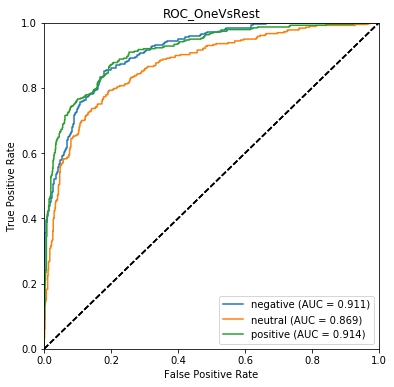

In [22]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [128]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.810450819672
0.618169398907
0.392076502732


0.889530046105


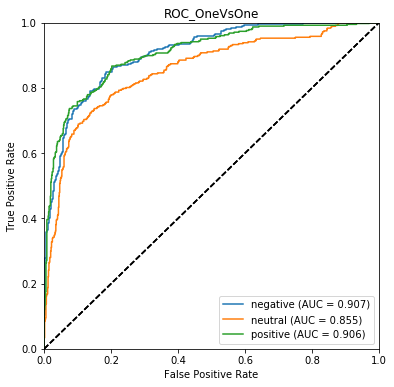

In [24]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [129]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.779030054645
0.544057377049
0.274931693989


0.839490353222


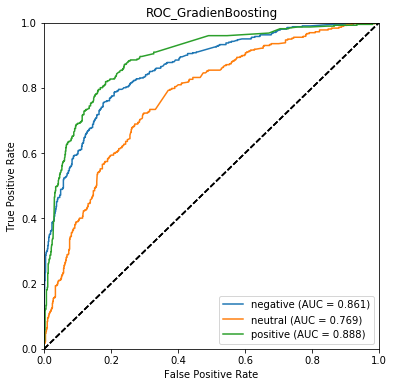

In [77]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [130]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.766393442623
0.462090163934
0.125341530055


0.873176098499


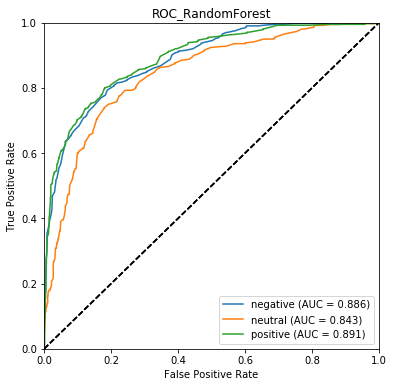

In [79]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [131]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.810109289617
0.603483606557
0.364412568306


0.897398721969


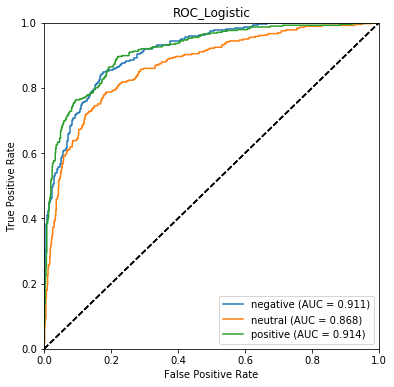

In [26]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [27]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [132]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.749559082892
0.723104056437
0.594356261023


0.895770169448


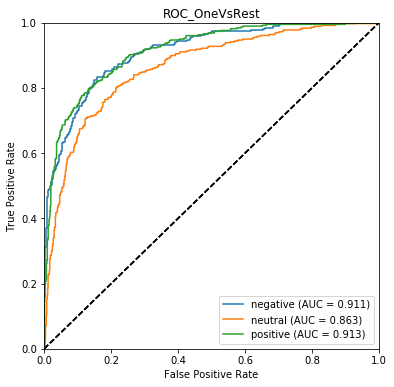

In [133]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [134]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.035))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.747795414462
0.726631393298
0.601410934744


0.88708801867


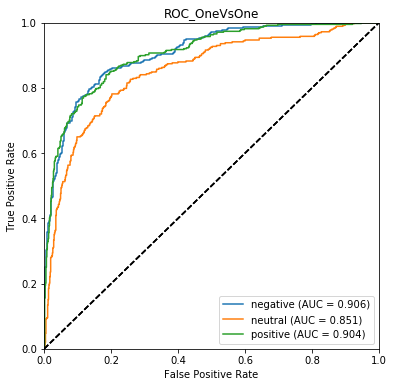

In [135]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [136]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.733686067019
0.701940035273
0.571428571429


0.844834230405


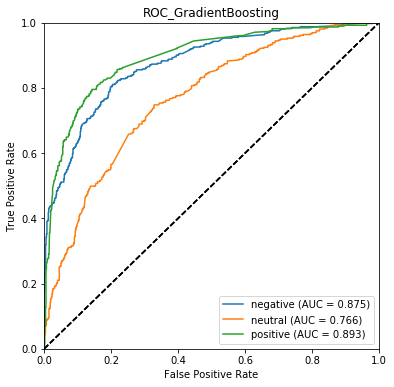

In [137]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [138]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.725749559083
0.714285714286
0.592592592593


0.889778538775


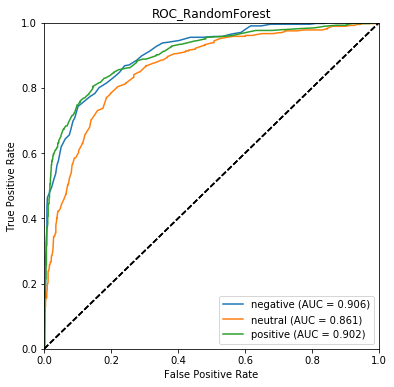

In [139]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [140]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.751322751323
0.714285714286
0.58024691358


0.894731977958


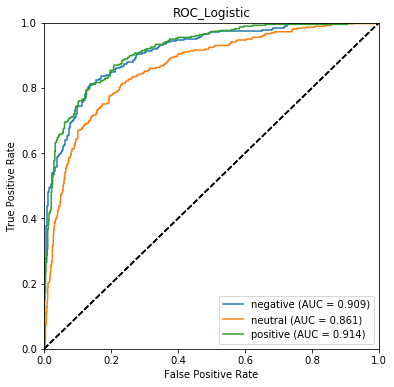

In [141]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [142]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.76102292769
0.73897707231
0.620811287478


0.901404483006


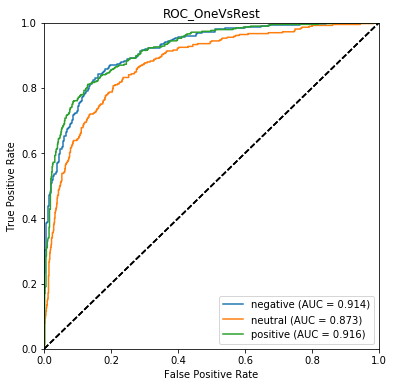

In [144]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [145]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.06))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.754850088183
0.73544973545
0.620811287478


0.89100607373


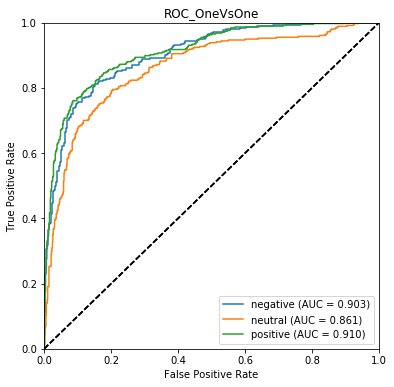

In [146]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [147]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.732804232804
0.685185185185
0.544091710758


0.837769367777


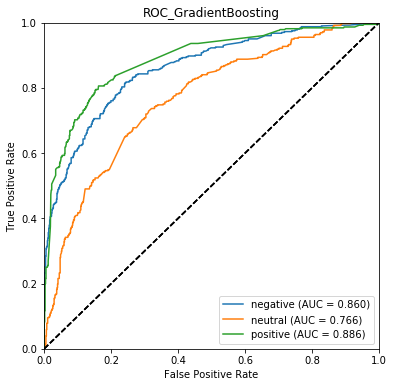

In [148]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [149]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.703703703704
0.712522045855
0.610229276896


0.883768040986


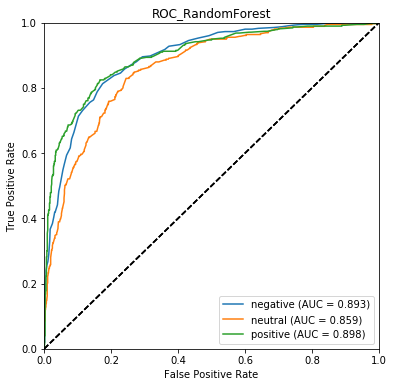

In [150]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [151]:
clf_log=linear_model.LogisticRegression(C=0.85)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.753968253968
0.715167548501
0.581128747795


0.901173106979


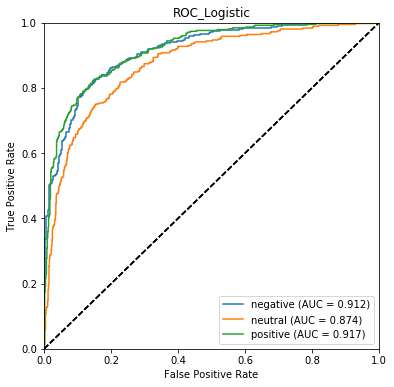

In [152]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Using preprocessed data

In [153]:
# use remove_1
tweet = balanced_data['remove_1']

In [154]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.747795414462
0.725749559083
0.600529100529


0.893609511419


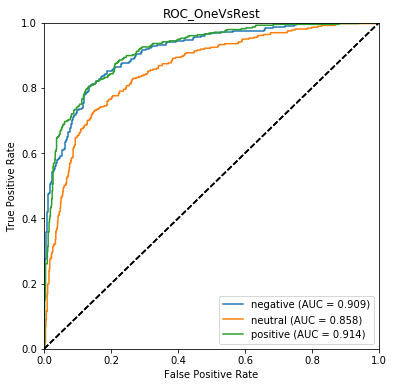

In [156]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [157]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.741622574956
0.722222222222
0.595238095238


0.885375745165


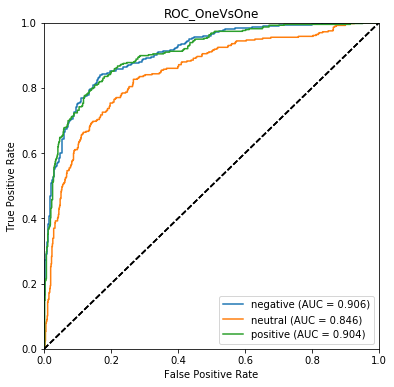

In [158]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [159]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.73544973545
0.699294532628
0.568783068783


0.846474508467


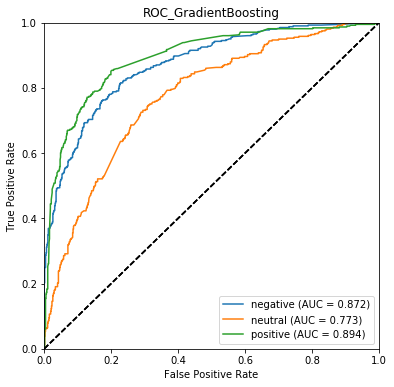

In [160]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [161]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.725749559083
0.690476190476
0.55291005291


0.886943568146


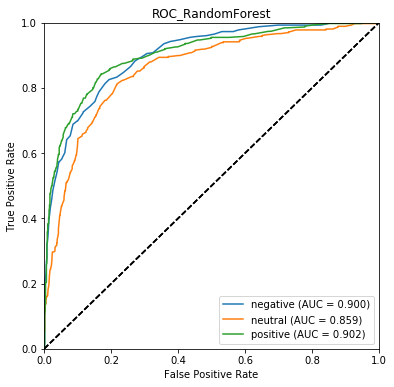

In [162]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [194]:
## 
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.756613756614
0.724867724868
0.596119929453


0.891812861991


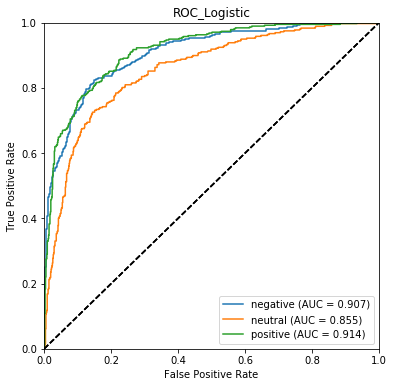

In [163]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [164]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [165]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.746031746032
0.678130511464
0.519400352734


0.896251804783


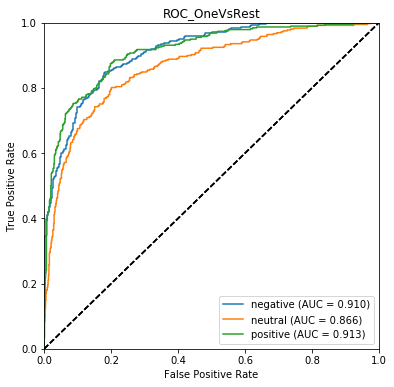

In [166]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [167]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.747795414462
0.697530864198
0.55291005291


0.888194209628


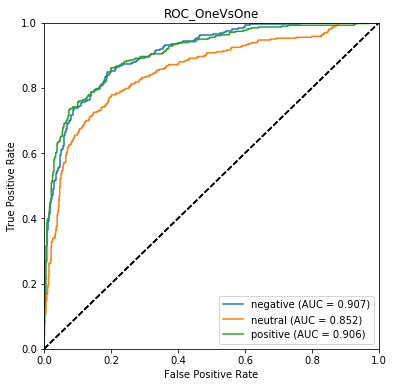

In [168]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [169]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.715167548501
0.664902998236
0.511463844797


0.837136534155


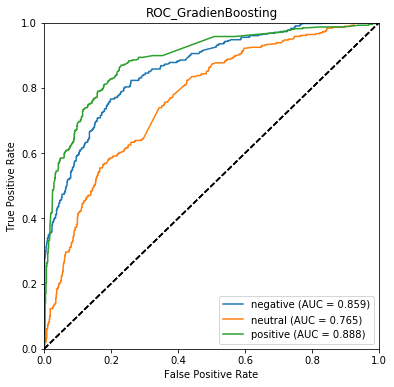

In [170]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [171]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.70811287478
0.618165784832
0.420634920635


0.871260857785


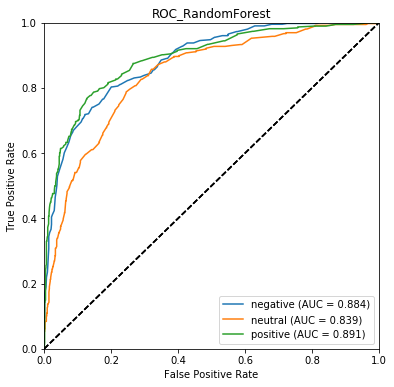

In [172]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [173]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.750440917108
0.691358024691
0.541446208113


0.896104341485


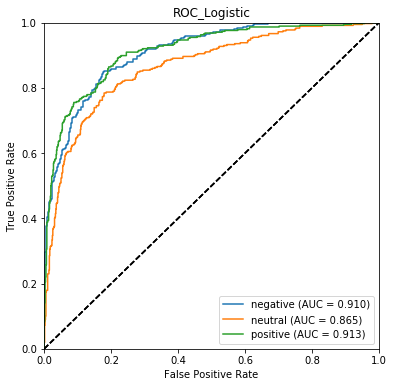

In [174]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [175]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.754850088183
0.723985890653
0.598765432099


0.901679230156


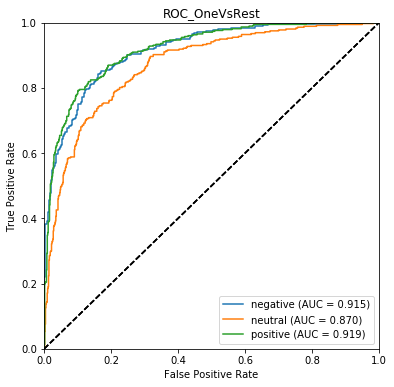

In [177]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [178]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.753968253968
0.725749559083
0.602292768959


0.892665099521


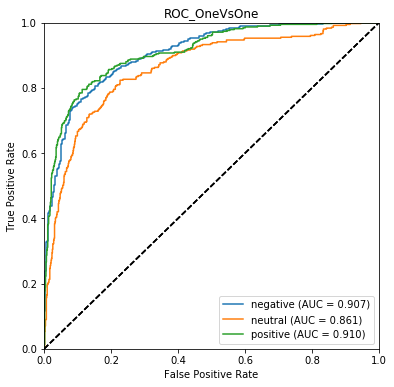

In [179]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [180]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.724867724868
0.699294532628
0.574074074074


0.846544502283


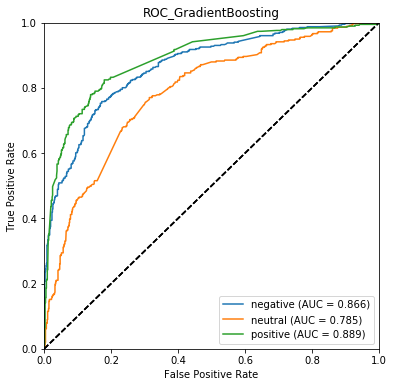

In [181]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [182]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.70987654321
0.722222222222
0.625220458554


0.886051532895


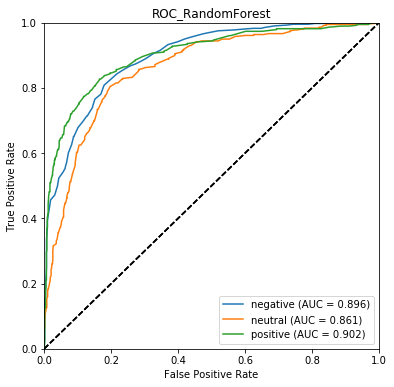

In [183]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [184]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.758377425044
0.723104056437
0.592592592593


0.90200859084


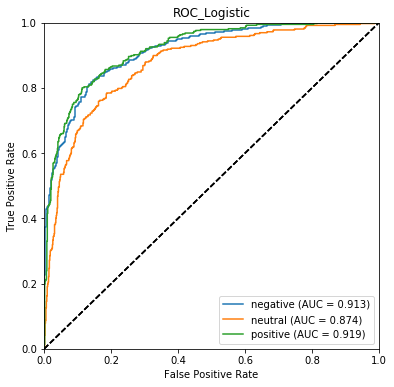

In [185]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [186]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.755731922399
0.727513227513
0.60405643739


0.900413289439


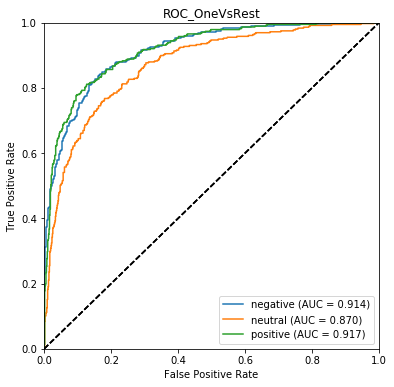

In [188]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [189]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.753968253968
0.736331569665
0.621693121693


0.890011625925


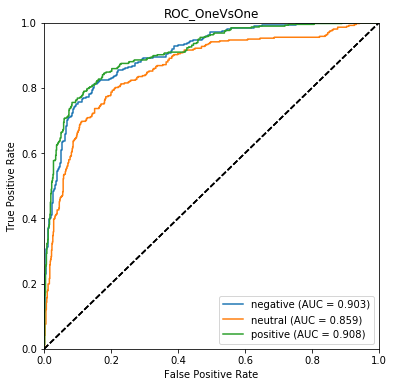

In [190]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [46]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.789617486339
0.58606557377
0.342213114754


0.839680241002


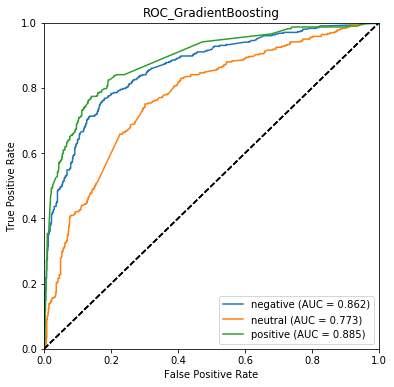

In [144]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [47]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.775614754098
0.467896174863
0.131830601093


0.880391220245


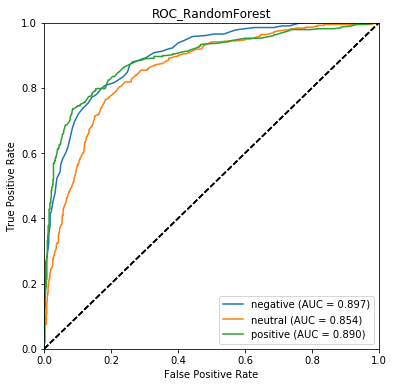

In [146]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [48]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.806010928962
0.644467213115
0.446379781421


0.900294111801


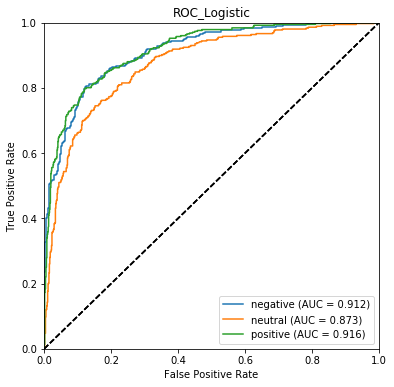

In [69]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [70]:
# use remove_2
tweet = balanced_data['remove_2']

In [71]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.806010928962
0.64924863388
0.455942622951


0.891936656671


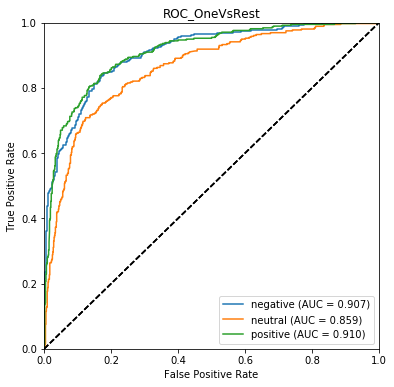

In [73]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [50]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.800887978142
0.654371584699
0.468579234973


0.882534250092


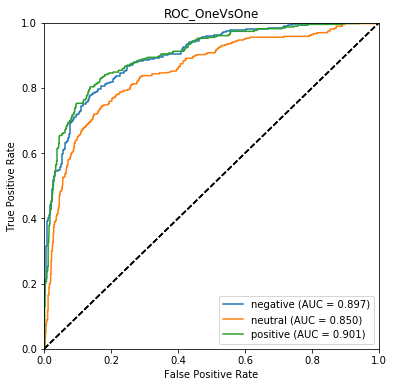

In [75]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ("tt")

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')


# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print("tt")

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

0.728395061728
0.700176366843
0.573192239859
tt


In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.892354364488


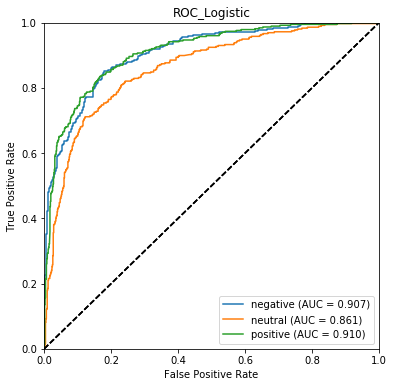

In [77]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [ ]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.892364028095


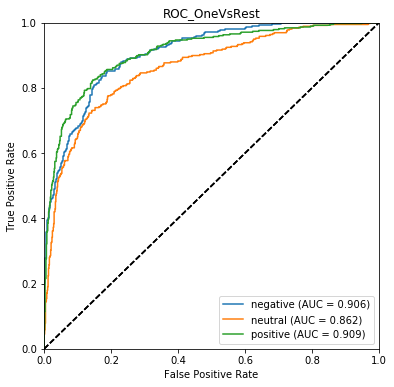

In [80]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.881760831314


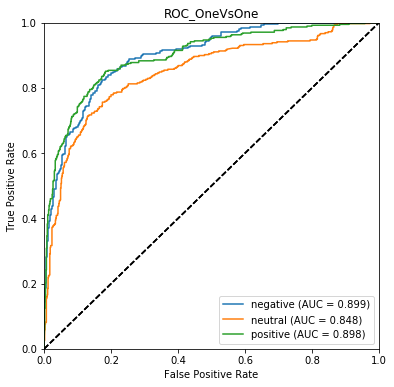

In [82]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [ ]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')


plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.892416309691


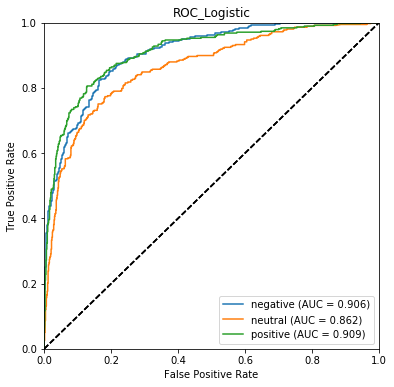

In [84]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [85]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.899877022645


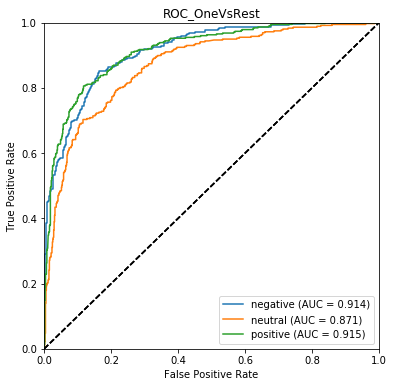

In [87]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)
w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.889245181912


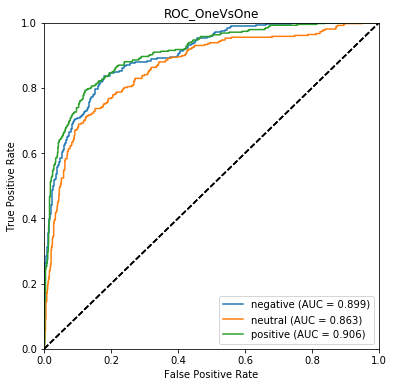

In [89]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ('tt')
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.899266684869


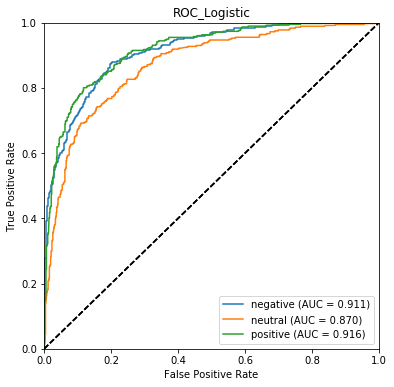

In [90]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.898704754779


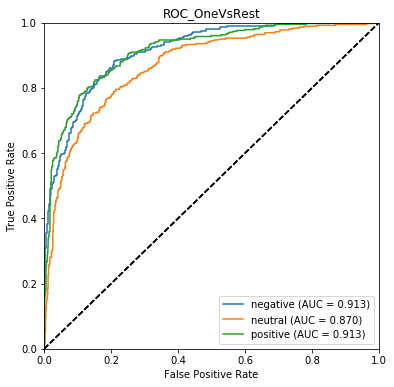

In [94]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.887079543222


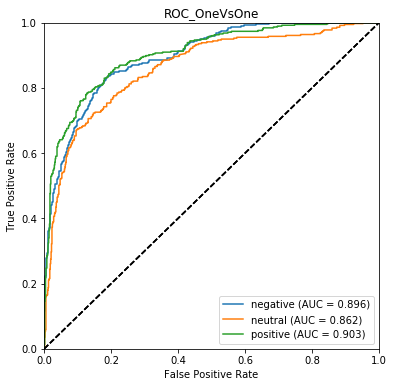

In [96]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print("tt")

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5)) 
print('tt')
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.899173777275


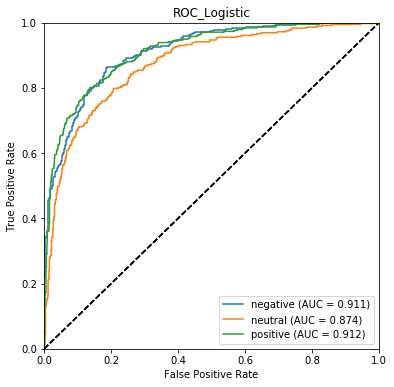

In [99]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [181]:
# use remove_3
tweet = balanced_data['remove_3']

In [ ]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.893633833313


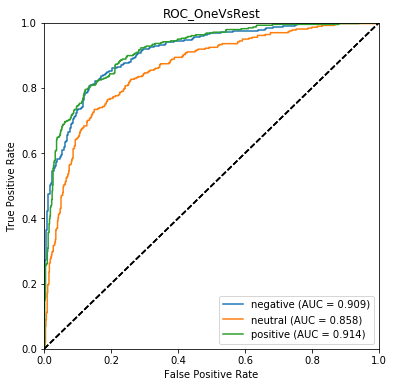

In [184]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')


plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.893834061379


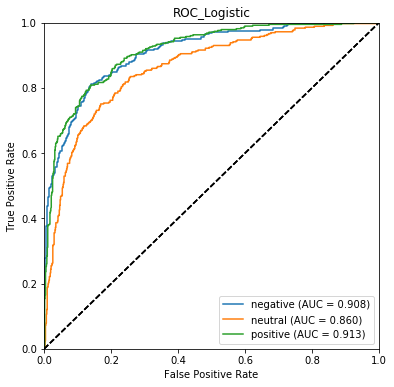

In [189]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [ ]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.896031035591


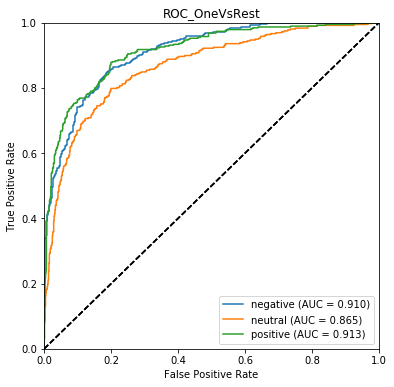

In [192]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.887491342182


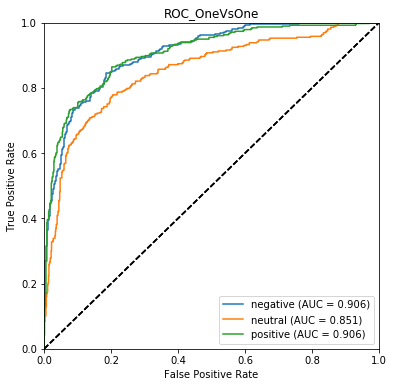

In [194]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [ ]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ("tt")

plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')

plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.895827429692


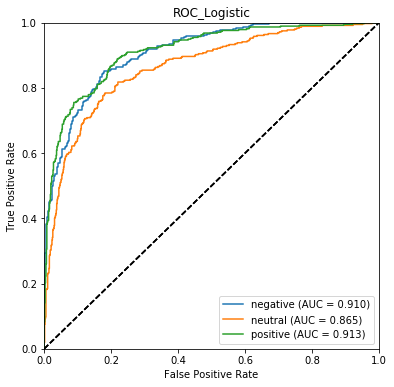

In [197]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [ ]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.901605295442


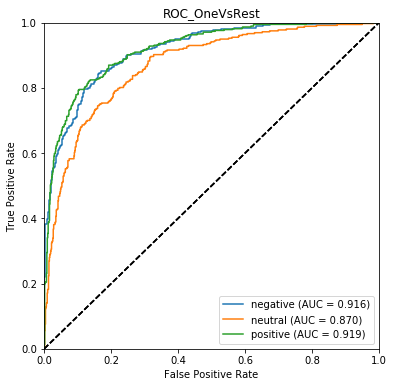

In [200]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.89266302239


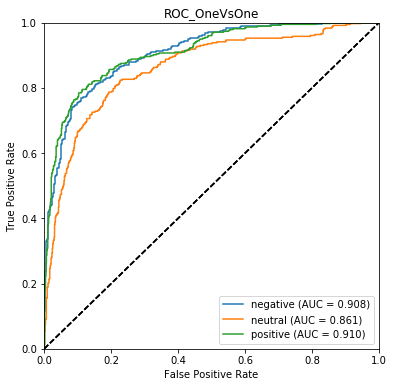

In [202]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')


plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print("tt")

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.901950221685


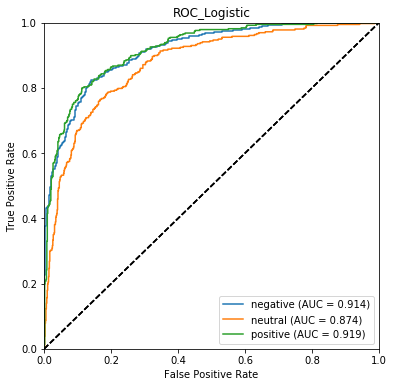

In [205]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.900402080714


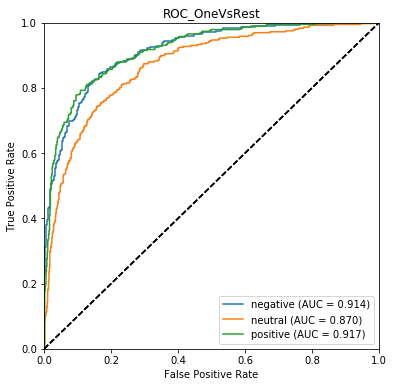

In [208]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.889867028204


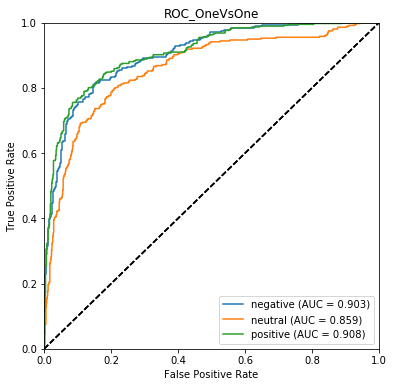

In [210]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ("tt")

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print("tt")

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# use remove_5
tweet = balanced_data['remove_5']

In [ ]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.895791221249


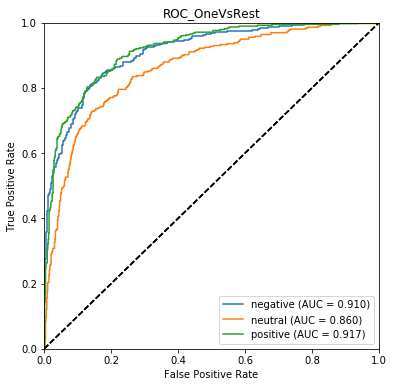

In [217]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.887597238374


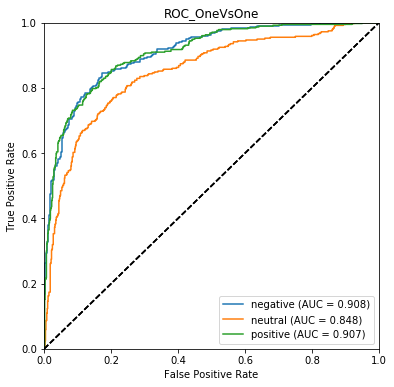

In [219]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.846470697337


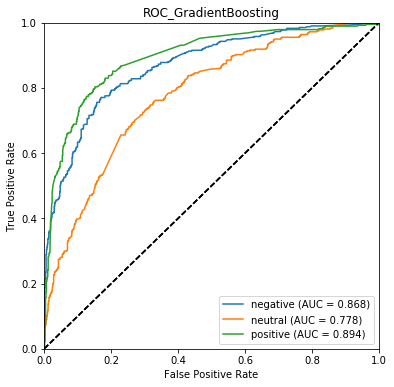

In [221]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))


In [ ]:
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.888054344382


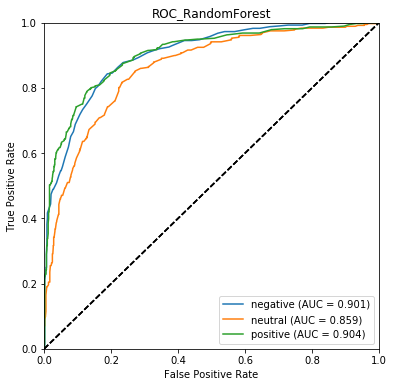

In [223]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.896109728232


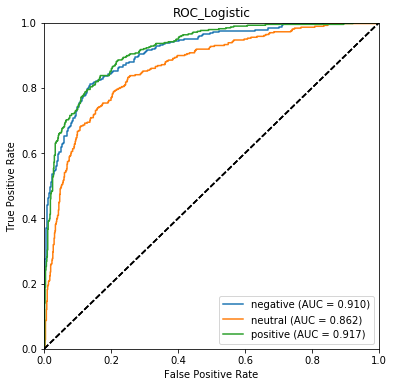

In [225]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [ ]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.898871745408


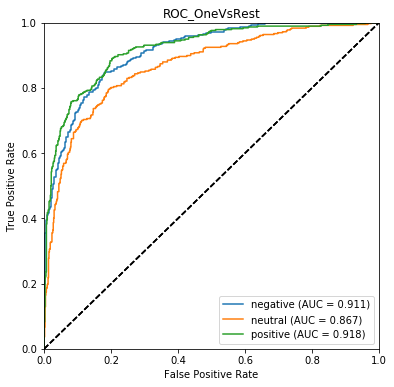

In [228]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.889348385479


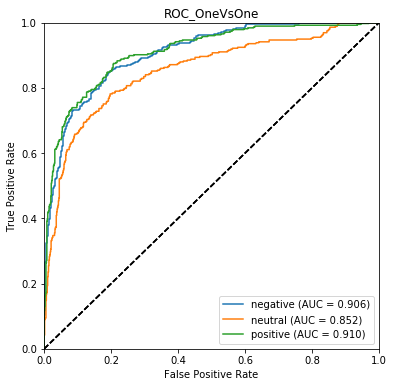

In [230]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [ ]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.839595654843


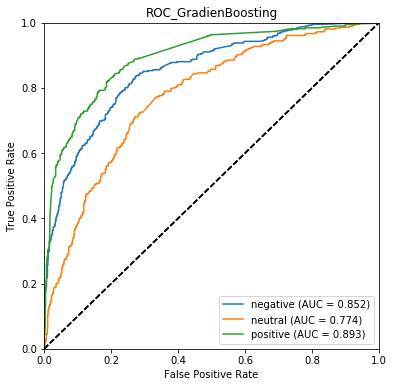

In [232]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [ ]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.873866497145


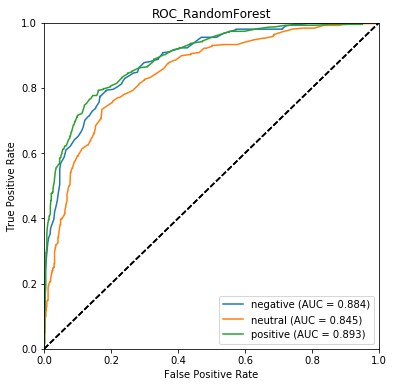

In [234]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.898627952308


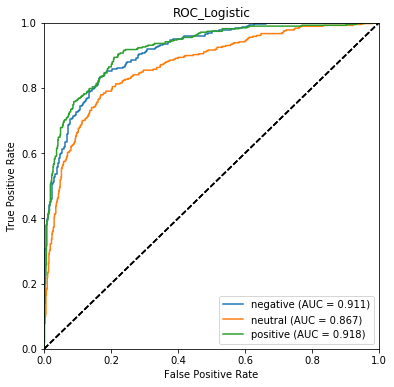

In [236]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [ ]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.903184120326


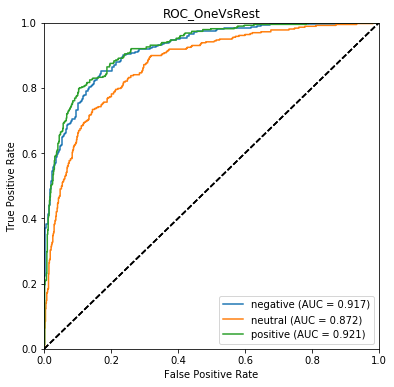

In [239]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.894240492741


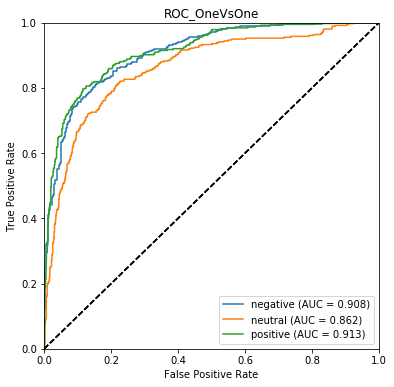

In [241]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.903407991713


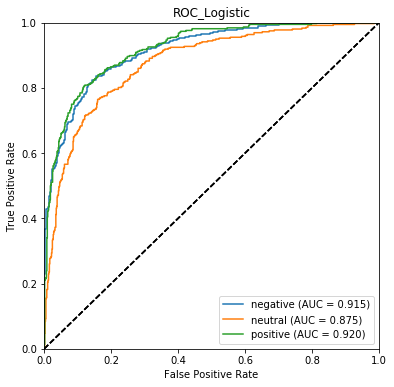

In [244]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.901812244097


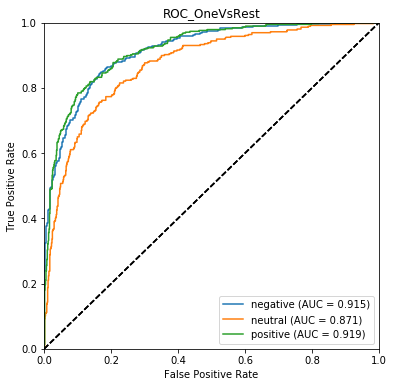

In [247]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.891112842438


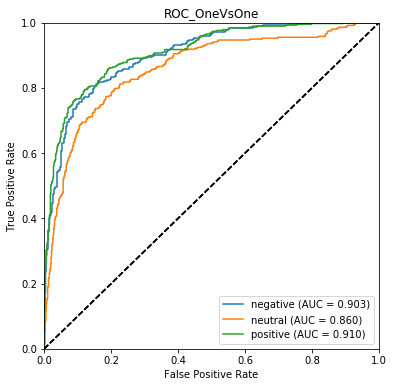

In [249]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ('tt')

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.901570017143


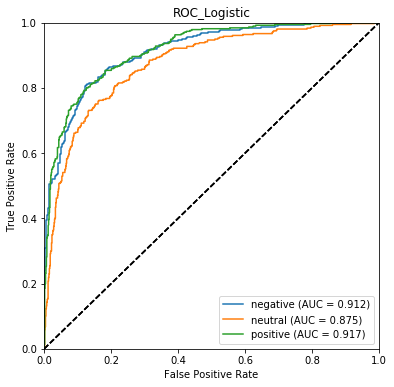

In [252]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# use remove_6
tweet = balanced_data['remove_6']

In [ ]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.896309571325


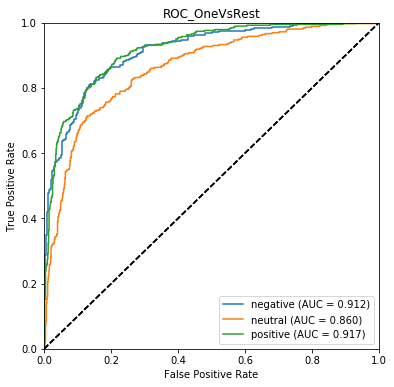

In [256]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.887006282066


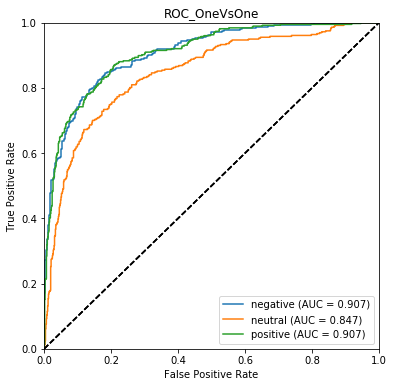

In [258]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ("tt")


plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ('tt')

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.896542077513


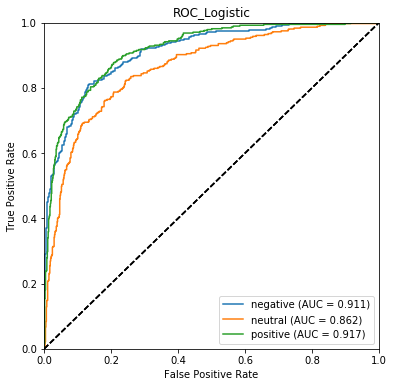

In [261]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [ ]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(tX_train, ty_train)
clf_ovr.predict(tX_train)

accuracy = np.mean(ty_valid == clf_ovr.predict(tX_valid))
print(accuracy)
    
w = metrics.confusion_matrix(ty_valid, clf_ovr.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.89905926237


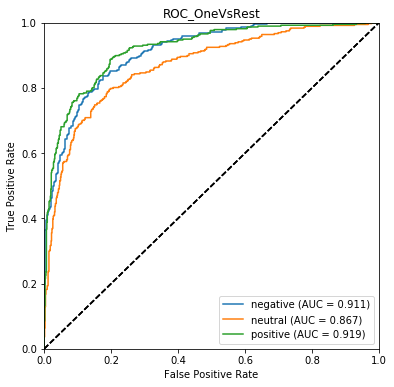

In [264]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_ovo.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.889135490867


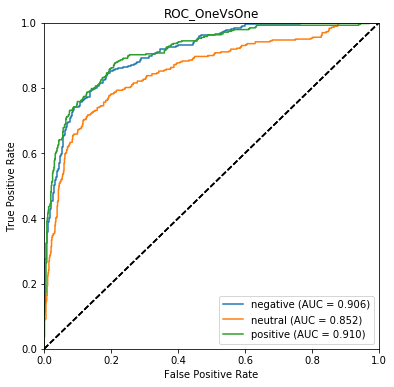

In [266]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [ ]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

w = metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.898945076847


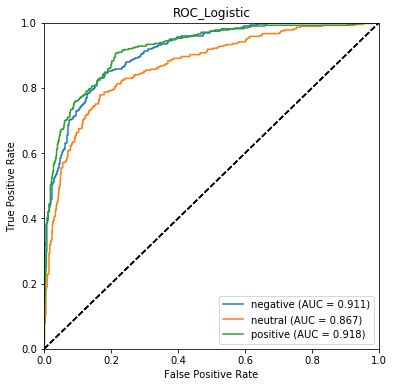

In [269]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [ ]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.903282286935


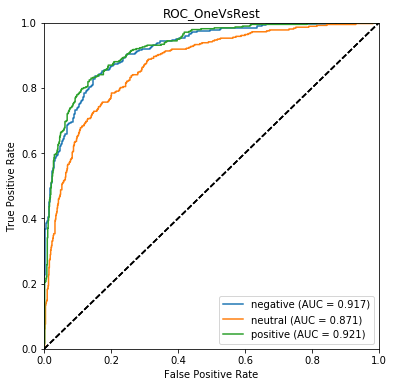

In [272]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.894562918762


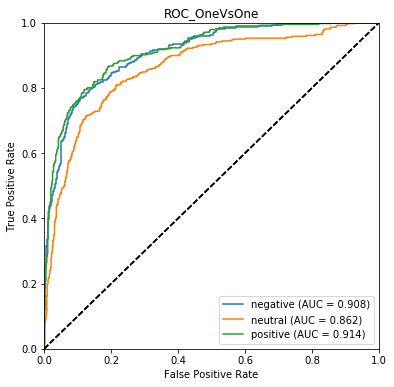

In [274]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ("tt")

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print ('tt')

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.903635965445


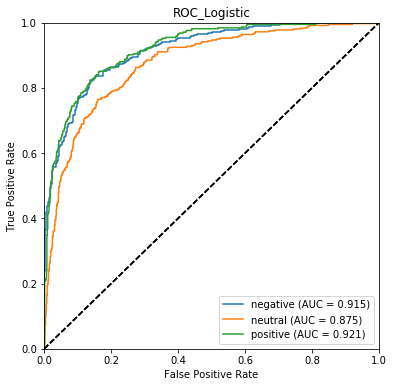

In [277]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
w = metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.902244114363


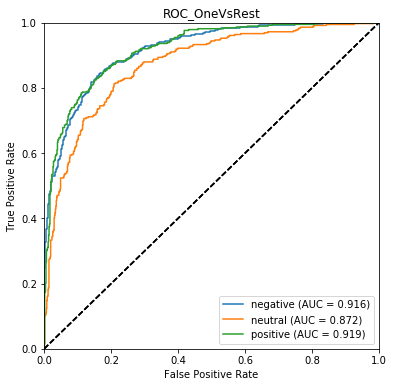

In [280]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [ ]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.891288223168


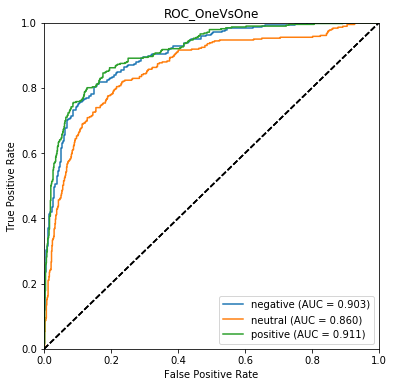

In [282]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))
print('tt')

plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [ ]:
clf_log=linear_model.LogisticRegression(C=0.7)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

w = metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))
print(w_accuracy(w,1,3))
print(w_accuracy(w,1,5))

0.901633703461


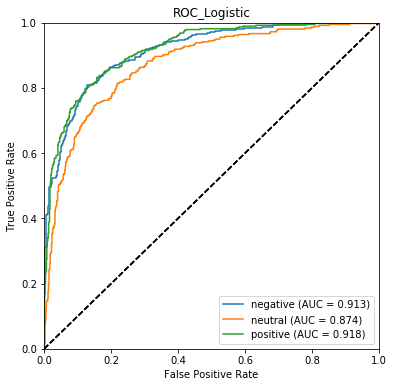

In [285]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [ ]:
y_raw = data['airline_sentiment']
y = np.zeros(len(y_raw))
for i in range(len(y_raw)):
    if np.array(y_raw)[i] == 'negative':
        y[i] = 1
    else:
        y[i] = 0

In [ ]:
tweet = data['text']

In [ ]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf_svc = svm.LinearSVC(C=0.05)
clf_svc.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_svc.predict(X_valid))
print(accuracy)

In [290]:
def plotRocCurve_bi(X_train, y_train, X_valid, y_valid, model, modelname):
    if modelname == 'RandomForest':
        y_score = model.fit(X_train, y_train).predict_proba(X_valid)
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_valid)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_valid, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    fig = plt.figure(figsize = (6, 6))

    # Plot ROC curve
    plt.plot(fpr, tpr, label = ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC_' + modelname)
    plt.legend(loc="lower right")

0.927611348168


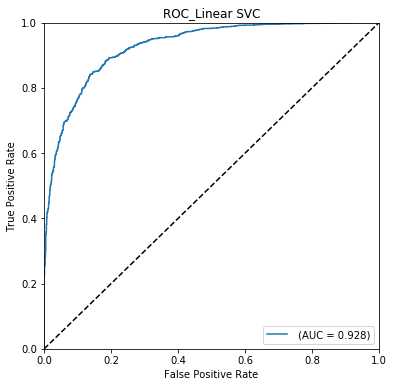

In [291]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_svc, 'Linear SVC')

In [292]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.855191256831


0.929253896227


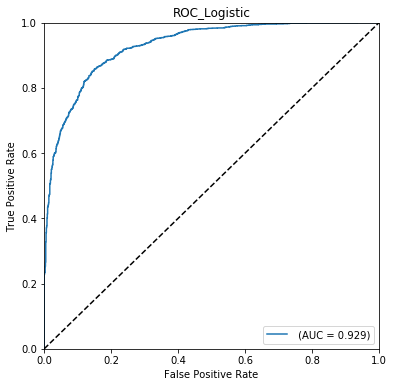

In [293]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [294]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

0.834016393443


0.9005351188


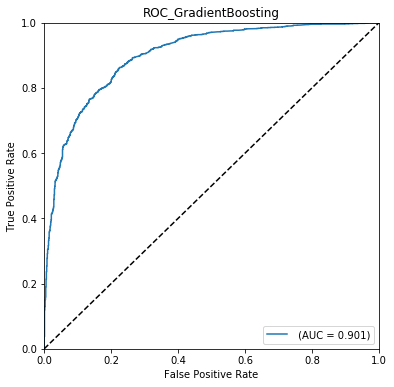

In [295]:
plotRocCurve_bi(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [296]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

0.834016393443


In [297]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [298]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.859289617486


0.927696056932


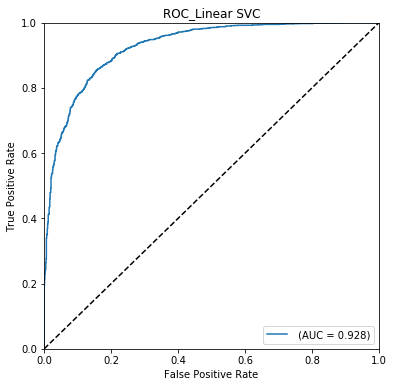

In [299]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [300]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.856215846995


0.928518082815


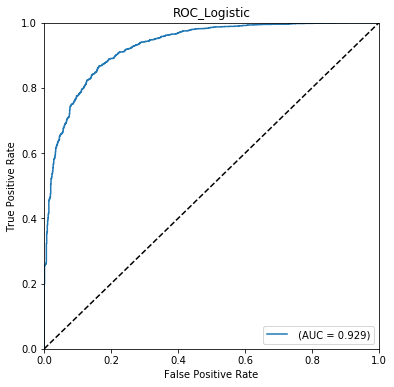

In [301]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [302]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

0.824453551913


0.891627917001


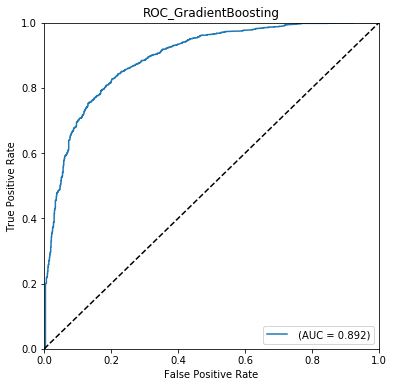

In [303]:
plotRocCurve_bi(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradientBoosting')

In [304]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_rfc.predict(tX_valid))
print(accuracy)

0.815573770492


In [305]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

ValueError: bad input shape (2928, 2)

In [306]:
tweet = data['remove_5']

In [307]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [308]:
clf_svc = svm.LinearSVC(C=0.03)
clf_svc.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_svc.predict(X_valid))
print(accuracy)

0.856215846995


0.929198008492


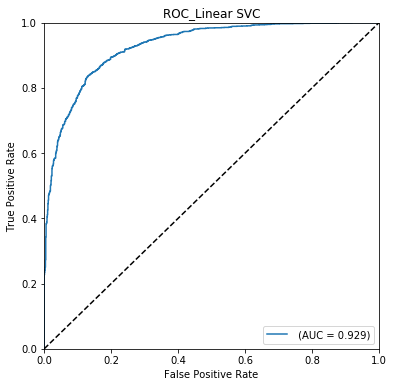

In [309]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_svc, 'Linear SVC')

In [310]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.858948087432


0.929784955022


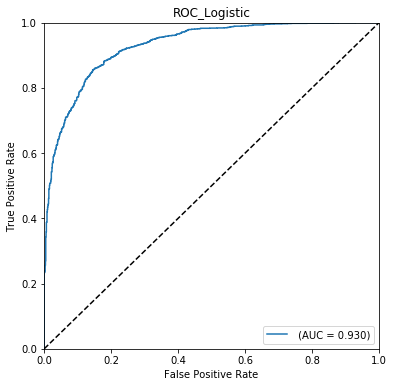

In [311]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [312]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [313]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.857923497268


0.928658428698


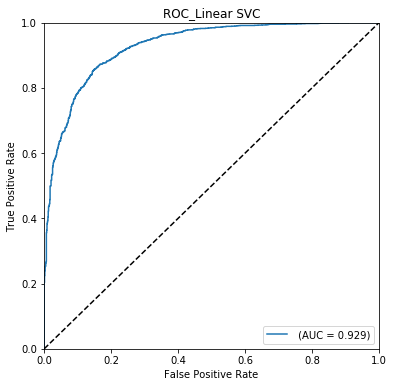

In [314]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [315]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.856898907104


0.929391234698


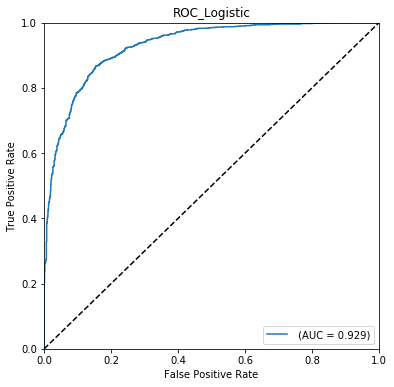

In [316]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [317]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(loss='exponential', learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

0.825819672131


0.898045232475


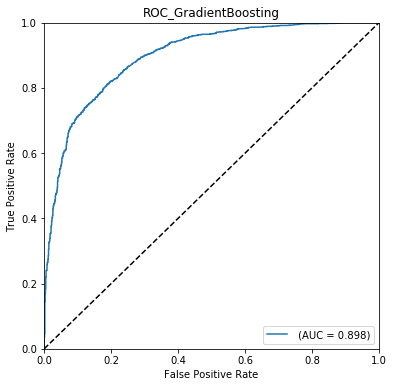

In [318]:
plotRocCurve_bi(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradientBoosting')

In [319]:
tweet = data['remove_6']

In [320]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [346]:
# bigram
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
clf_log=linear_model.LogisticRegression(C=0.4)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.867486338798


0.9336900792


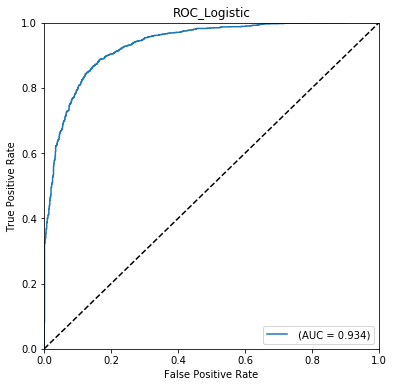

In [358]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [359]:
# trigram
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [370]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.866120218579


0.932546260258


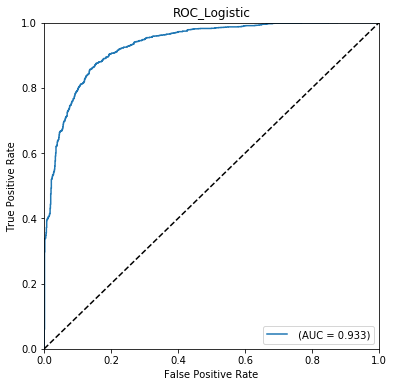

In [371]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [323]:
clf_log=linear_model.LogisticRegression(C=0.3)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

0.857923497268


0.929933320669


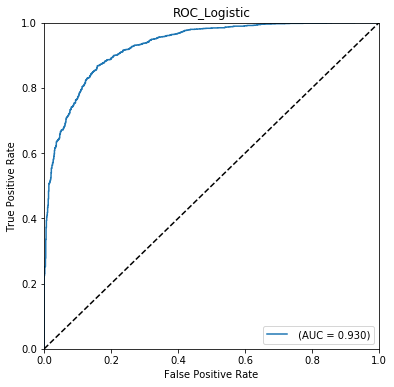

In [324]:
plotRocCurve_bi(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [325]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [326]:
clf_svc = svm.LinearSVC(C=0.15)
clf_svc.fit(tX_train, ty_train)

accuracy = np.mean(ty_valid == clf_svc.predict(tX_valid))
print(accuracy)

0.859631147541


0.928818823992


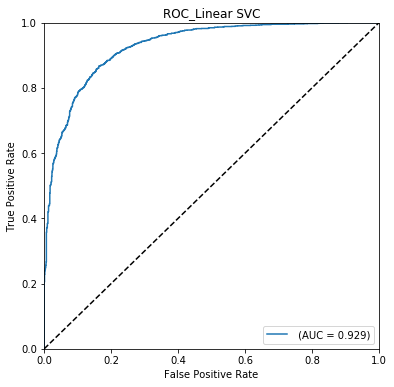

In [327]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_svc, 'Linear SVC')

In [328]:
clf_log=linear_model.LogisticRegression(C=2)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_log.predict(tX_valid))
print(accuracy)

0.859289617486


0.929496995345


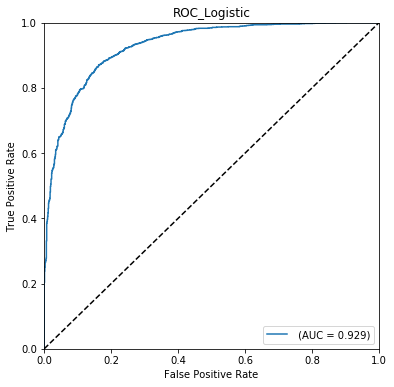

In [329]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [330]:
clf_sgd=linear_model.SGDClassifier(loss='log', penalty='l2', \
                                   alpha=1e-4, n_iter=100, \
                                   fit_intercept=False, random_state=42)
clf_sgd.fit(tX_train,ty_train)

accuracy = np.mean(ty_valid == clf_sgd.predict(tX_valid))
print(accuracy)

0.854849726776


0.927912089344


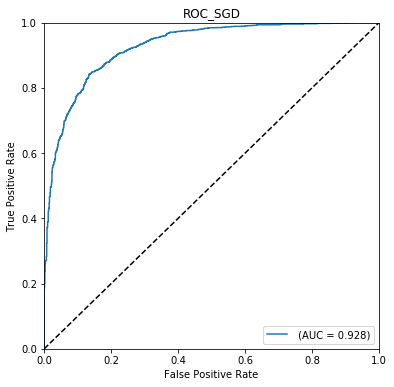

In [331]:
plotRocCurve_bi(tX_train, ty_train, tX_valid, ty_valid, clf_sgd, 'SGD')

In [94]:
# train on balanced data and validatio on imbalanced data
X_train, X_valid, y_train, y_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)
dtr=pd.DataFrame()
dtr['text'] = X_train
dtr['label'] = y_train
df0 = dtr[dtr['label']==0].sample(n=len(y_train[y_train==2]))
df1 = dtr[dtr['label']==1].sample(n=len(y_train[y_train==2]))
df2 = dtr[dtr['label']==2]
df_train = df0.append(df1).append(df2)
X_train = df_train['text']
y_train = df_train['label']
df_valid = pd.DataFrame()
df_valid['text'] = X_valid
df_valid['label'] = y_valid
df = df_train.append(df_valid)

In [95]:
# unigrams
count_vect = CountVectorizer()
count_vect.fit(df['text'])
X_tr = count_vect.transform(X_train)
X_val = count_vect.transform(X_valid)

In [96]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_tr, y_train)
clf_ovr.predict(X_tr)

accuracy = np.mean(y_valid == clf_ovr.predict(X_val))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_val))

0.741120218579


array([[1413,  347,  129],
       [  88,  410,   82],
       [  41,   71,  347]])

0.889190388714


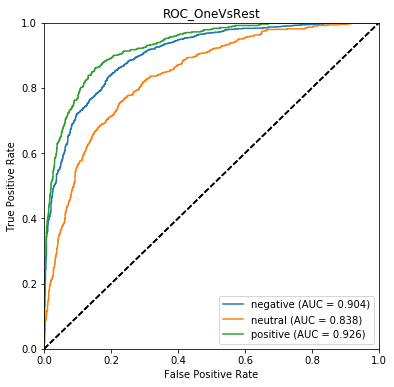

In [97]:
plotRocCurve(X_tr, y_train, X_val, y_valid, clf_ovr, 'OneVsRest')